In [412]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from tqdm.notebook import tqdm
from time import sleep
import scienceplots
import subprocess
pd.set_option('display.max_columns', None)
plt.style.use(['science','notebook']) #plt.style.use(['science','notebook'])
plt.tight_layout()
import warnings
warnings.filterwarnings("ignore")


<Figure size 800x600 with 0 Axes>

# Functions

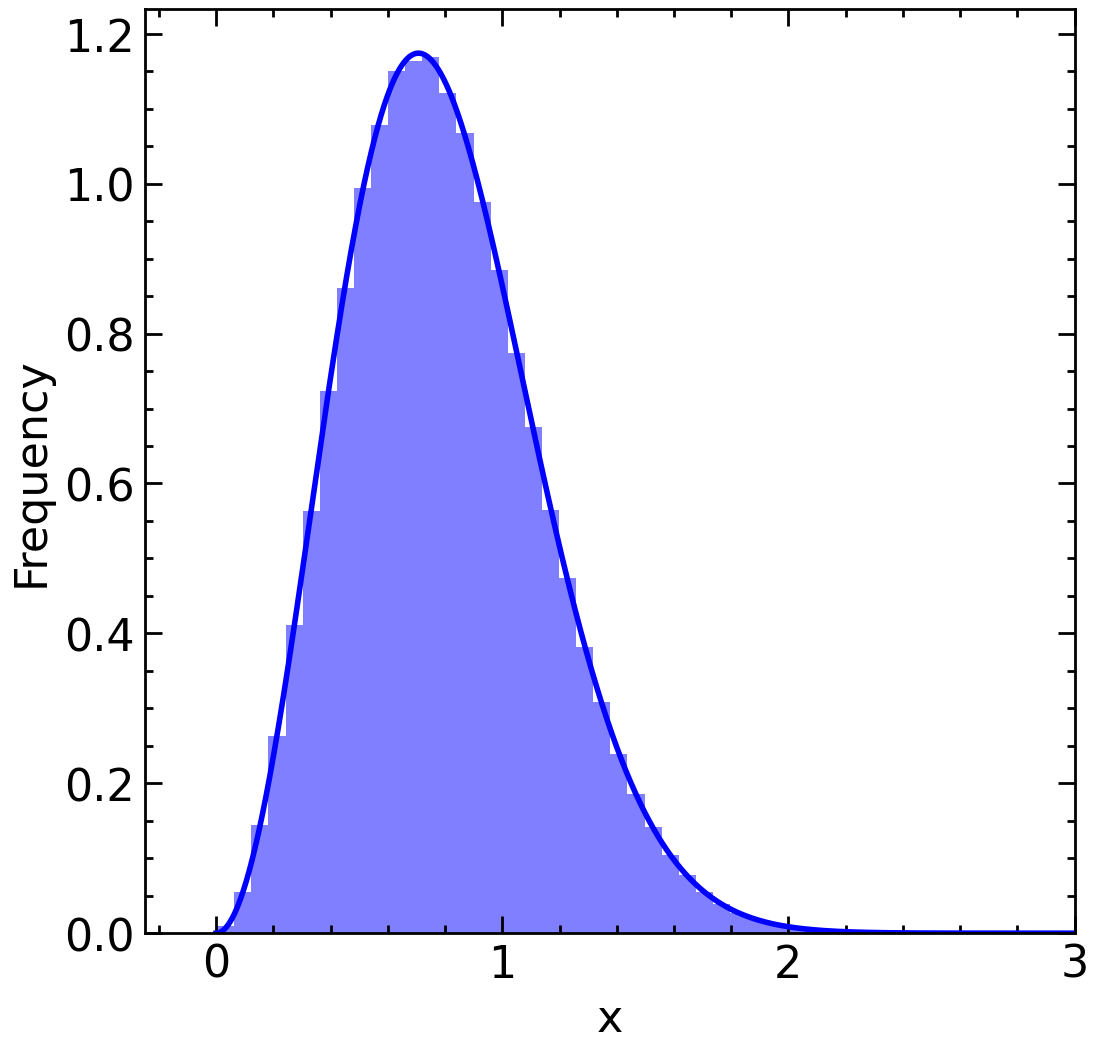

In [413]:

## FUNCTIONS
pi = np.pi
k2 = 4*pi*pi
MS_Types=[0.,1.]
WD_Types=[10.,11.,12.]
MSWD_Types=[0.,1.,10.,11.,12.]

cols =  [
        'N','t','t_n','sur','m1','m1_n','m2','m2_n','m3','m3_n',
        'e1','e1_n','e2','e2_n','a1','a1_n','a2','a2_n','i','i_n','P_in','P_in_n',
        'type1','type2','type3','type1_n','type2_n','type3_n',
        'G1o', 'G1n', 'G2o', 'G2n', 'Gtoto', 'Gtotn', 'cosi_o', 'cosi_n', 'needs_Re', 'Ad_or_Kick'
        ]

def Kepler_3rdLaw_SMA(m1,m2,SMA ): #M_sun and AU units, output in yr
    return np.power( ( (SMA**3)/(m1+m2) ) ,1./2.)

def epsilon(a1,a2,e2):
    return (   (a1/a2)* (  e2/(1-e2**2)  )  )

def get_tidal_locked_condition(row):
    a1,Roche1,e1,P1 = row['a1'],row['Roche1'],row['e1'],row['P_in']
    beta,spintot,spin2h = row['beta'],row['spintot'],row['spin2h']
    M_PI = np.pi
    
    tl_crit1 = (a1/Roche1 <= 5 or a1 <= 0.1) 
    tl_crit2 = ( e1 <= 1e-4 )
    tl_crit3 = (a1 <= 0.1 and e1 <= 1e-2)

    tl_condition = ( e1 <= 1e-2 and tl_crit1 and tl_crit2) or tl_crit3
    return tl_condition

def get_t_ekl(m1,m2,m3,e2,P1,P2):
    """
    Characteristic quadrupole timescale fro EKL (eq 27 from review)
    """
    return (8./(15*np.pi))*((m1+m2+m3)/m3)*(P2*P2/P1)*np.sqrt(1-e2*e2)*(1-e2*e2)

# can also use this for a2 if inner binary is in c=
def get_a_n(m1,m2,m2n,e1,EA1,a_i, uk=0,theta=0): #(10) in Lu+2019

    B = (m1+m2n) / (m1+m2)
    a1_ratio = B * (1-e1*np.cos(EA1)) / (  2*B - (1+e1*np.cos(EA1))* (1+uk*uk + 2*uk*np.cos(theta))     )
    return a1_ratio * a_i
"""
"""
def a2_n(m1,m2n,m3,a2,e2,E2):
    M = m1 + m2n + m3
    R = a2( 1 - e2*np.cos(E2) )
    
    fv = k2 * M * (2/R  - 1/a2)
    inv = 2 / (a2*(1-e2*np.cos(E2)))   -  fv*fv / ( k2* (m1+m2n + m3) )
    a2n = 1/inv
    
    return a2n

def get_e1_n(r,vr,a1n,m1,m2n,theta=90): #(19) from Lu et al.
    
    e_squared = 1 - np.power(r*vr*np.sin(theta), 2) / (a1n* k2 * (m1+m2n))
    
    return np.sqrt(e_squared)

def get_e2_n(m1,m2n,m3,a2n,R,V2n, theta=90):
    #theta = np.random.uniform(0,np.pi)
    M = m1 + m2n + m3
    term = np.power(a2n*k2*M  ,-1) * np.power(R*V2n*np.sin(theta),2)
    return 1 - term

def get_i(G1,G2,Gtot):
    cosi = (Gtot**2 - G1**2 - G2**2 ) / (2*G1*G2)
    
    return np.arccos(cosi)*180/pi #in degrees

def get_L_rigid(M, R, spin, shape = 'sphere'):
    if shape == 'sphere': 
        I = (2/5) * M * R**2
    w = 2*pi*spin
    return I*w
    
def get_L1(m1,m2,a1):
    mu = (m1*m2 / (m1+m2) )
    L1 = mu * np.sqrt(k2 * (m1+m2)*a1)
    return L1

def get_h(m1,m2,a,e):
    
    hsqr = k2*(m1+m2)*a * np.sqrt(1-e*e)
    return np.sqrt(hsqr)

def get_G_from_h(m1,m2,h):
    mu = m1*m2 / (m1+m2)
    return mu*h

def get_L2(m1,m2,m3,a2):
    M = m1 + m2 + m3
    mu = m3*(m1+m2) / M
    L2 = mu * np.sqrt(k2*M*a2)
    return L2

def get_G(L,e):
    
    return L * np.sqrt(1-e*e)

def i_from_c(old_masses, new_masses,e1o,e1n,old_Gs,new_Gs):
    
    m1o,m2o,m3o = old_masses
    m1n,m2n,m3n = new_masses
    G1o, G2o = old_Gs
    G1n, G2n = new_Gs
    
    mu1o = (m1o * m2o) / (m1o+m2o)
    mu1n = (m1n * m2n) / (m1n+m2n)

    mu2o = m3o*(m1o + m2o) / (m1o+m2o+m3o) #mu2o
    mu2n = m3n*(m1n + m2n) / (m1n+m2n+m3n) #mu2n

    factor1 = np.sqrt(   (1-e1n*e1n) / (1-e1o*e1o) )
    alpha1 = (mu1n/mu1o) * G1o * factor1
    alpha2 = (mu2n / mu2o) * G2o
    
    cosi_n = 0.5 * (    ( alpha1**2 + alpha2**2 - (G1n**2 + G2n**2) ) / (G1n*G2n - alpha1*alpha2)  )
    
    return np.arccos(cosi_n) *180/pi
    
def new_Gtot_from_i(initial_masses : tuple, new_masses : tuple, G10 : float, G20 : float, i0 : float,
                      e1_i : float, e1_n : float) -> float:
    """Get Gtot new from the old G's

    Args:
        initial_masses (tuple): m1o, m2o, m2o
        new_masses (tuple): m1n, m2n, m3n
        G10 (float): old G1
        G20 (float): old G2
        i0 (float): Old total inclination
        old_eccs (float): e1o,e2o
        new_eccs (float): e1n,e2n
    Returns:
        _type_: new G
    """
    
    m1o, m2o, m3o = initial_masses 
    m1n, m2n, m3n = new_masses
    
    e1o = e1_i
    e1n = e1_n
    
    mu1o = (m1o * m2o) / (m1o+m2o)
    mu1n = (m1n * m2n) / (m1n+m2n)
    
    mu2o = m3o*(m1o + m2o) / (m1o+m2o+m3o) #mu2o
    mu2n = m3n*(m1n + m2n) / (m1n+m2n+m3n) #mu2n
    
    factor1 = np.sqrt( (1-e1n*e1n) / (1-e1o*e1o)     )
    G10_u = G10*factor1

    Gsqr = ( (  (mu1n/mu1o)**2  ) * G10_u**2  )  + ( (  (mu2n/mu2o)**2  ) * G20**2   ) + 2*(mu1n/mu1o)*(mu2n/mu2o) * G10_u*G20*np.cos(i0)
    
    return np.sqrt(Gsqr)

def new_i_from_stuff(initial_masses : tuple, new_masses : tuple, i0 : float,
                      e1_i : float, e1_n : float, e2_i : float,  
                      a1n : float, a2 : float) -> float:
    
    m1 , m2 , m3  = initial_masses 
    m1n, m2n, m3n = new_masses
    
    e1o = e1_i
    e2o = e2_i
    e1n = e1_n
    e2n = e2_i
    #mu1  = (m1  * m2 ) / (m1 +m2 )
    mu1n = (m1n * m2n) / (m1n + m2n)
    
    mu2  = m3 *(m1  + m2 ) / (m1 +m2 +m3 ) #mu2o
    mu2n = m3n*(m1n + m2n) / (m1n+m2n+m3n) #mu2n
    
    L1 = mu1n * np.sqrt(k2*(m1+m2)*a1n)
    L2 = mu2n * np.sqrt(k2*(m1+m2+m3)*a2)
    
    G1n   =  mu1n*np.sqrt((m1n + m2n) * a1n * (1-e1n**2))       #L1 * np.sqrt(1-e1n**2) #mu1n*np.sqrt((m1n + m2n) * a1n * (1-e1n**2)) 
    G2    =  mu2 *np.sqrt((m3 * (m1 + m2) * a2 * (1-e1o**2)))   #L2 * np.sqrt(1-e2n**2) #mu2 *np.sqrt((m3 * (m1 + m2) * a2  * (1-e1o**2))) 
    
    G2n=(mu2n/mu2)*G2
    Gtotn2 = G1n**2 + G2n**2 + 2* G1n * G2n * np.cos(i0*pi/180) 
    
    cosin=(Gtotn2-G1n**2-G2n**2)/(2.*G1n*G2n)
    
    return np.arccos(cosin)*180/pi
    
def get_r_mag(a,ecc,EA):
    
    return a*(1 - ecc*np.cos(EA))

def get_vr(m1,m2,r,a):
    mu = k2*(m1+m2)
    return np.sqrt( mu* (2/r - 1/a)    )
# af = (mi/mf)ai, mi and mf are total mass of inner binary
def get_a_adiabatic(initial_masses : tuple ,final_masses : tuple ,ai :float):
    
    Mi = sum(initial_masses)
    Mf = sum(final_masses)
    
    return ( (Mi/Mf) * ai )
    
def sample_angle(sampler='uniform'): #Sample eccentric anaomly
    if sampler == 'uniform':
        return np.random.uniform(0,np.pi)
    
def get_r_avg(a,e):
    
    return a*(1+0.5* np.power(e,2)   ) #time averages separation in two body orbit

# Distribution of kick magnitudes 

def my_pdf(vk):
    sigma = 0.5 #km/s
    return (np.sqrt(2/np.pi) * (vk**2)/(sigma**3) * np.exp(-1* (vk**2) / (2*sigma**2) ))

# Define the range of x values to consider
x = np.linspace(0, 5, 10000)
plt.figure(figsize=(6,6))
# Plot the PDF
plt.plot(x, my_pdf(x),color='b')
plt.xlabel('x')
plt.ylabel('PDF')

# Choose random values from the PDF
num_samples = 10000000 # Number of random samples to choose
samples = np.random.choice(x, size=num_samples, p=my_pdf(x)/np.sum(my_pdf(x)))

# Plot the histogram of the random samples
plt.hist(samples, density=True, bins=50, histtype='stepfilled', lw=3, fc=(0, 0, 1, 0.5))
plt.xlim(right=3)
plt.xlabel('x')
plt.ylabel('Frequency')
plt.show()


def get_a2_kick(m1_i, m2_i, m1_n, m2_n, e_i, a_i, sample=False, N_sample = 1000, zero_kick=False):
    
    # IF NO SAMPLE, JUST USE MEDIAN KICK
    theta=np.random.uniform(0,np.pi)
    EA1, EA2 = np.random.uniform(0,np.pi), np.random.uniform(0,np.pi)
    
    R = get_r_mag(a_i,e_i,EA2)
    vr = get_vr(m1_i, m2_i, R, a_i)
    v_kick = 0.75 * 0.210805 # in AU/yr
    uk = v_kick/vr
    
    a_n = get_a_n(m1 = m2_i, m2 = m1_i, m2n = m1_n, e1=e_i, EA1=EA2, a_i = a_i, uk = uk, theta=theta)
    e_n = get_e1_n(R, vr, a_n, m1_n, m2_n)
    # IF WANT TO SAMPLE MANY KICKS
    if sample:
        unbound_count = 0
        sum_of_SMAs = 0
        good_SMAs, good_eccs = [], []
        n = N_sample
        v_kick = np.random.choice(samples) * 0.210805
        
        for i in range(n):
            if zero_kick: v_kick = 0
            theta=np.random.uniform(0,2*np.pi)
            # cost = np.random.uniform(np.cos(0),np.cos(np.pi))
            # theta = np.rad2deg(np.arccos(cost))

            EA1, EA2 = np.random.uniform(0,np.pi), np.random.uniform(0,np.pi)
            R = get_r_mag(a_i,e_i,EA2)
            vr = get_vr(m1_i, m2_i, R, a_i)
            uk = v_kick/vr
            
            a_n_sample = get_a_n(m1 = m2_i, m2 = m1_i, m2n = m1_n, e1=e_i, EA1=EA2, a_i = a_i,uk = uk, theta=theta)
            e_n_sample = get_e1_n(R, vr, a_n_sample, m1_n, m2_n)
            
            if a_n_sample < 0: 
                unbound_count += 1
            else:
                sum_of_SMAs += a_n_sample 
                good_SMAs.append(a_n_sample) 
                
            if 0 <= e_n_sample <= 1: 
                good_eccs.append(e_n_sample) 
            
        if unbound_count>= n/2:
            a_n = 1e8 #the system is just unbound
            e_n = np.nan
        else:
            # a_n = sum_of_SMAs / (n-unbound_count) #if most were bound, then return the average of the bound a2s for sampled angles
            a_n = np.median(good_SMAs)
            e_n = np.median(good_eccs)
            
    return (a_n, e_n)

def get_star_type(row,type_col = 'type1'): #type_col =  'type1' or ;type2' or 'type3'
    
    if row[type_col] in MS_Types: return 'MS'
    if row[type_col] in RG_Types: return 'RG'
    if row[type_col] in WD_Types: return 'WD'
    else: return 'other'

def get_bin_type(row): 
    
    this_type = 'other'
    if row['startype1'] == 'MS' and row['startype2'] == 'MS': this_type =  'MSMS'
    if row['startype1'] == 'RG' and row['startype2'] == 'RG': this_type =  'RGRG'
    if row['startype1'] == 'WD' and row['startype2'] == 'WD': this_type =  'WDWD'
    
    if (row['startype1'] == 'MS' and row['startype2'] == 'RG') or (row['startype2'] == 'MS' and row['startype1'] == 'RG'):  this_type =  'RGMS'
    if (row['startype1'] == 'MS' and row['startype2'] == 'WD') or (row['startype2'] == 'MS' and row['startype1'] == 'WD'):  this_type =  'WDMS'
    if (row['startype1'] == 'RG' and row['startype2'] == 'WD') or (row['startype2'] == 'RG' and row['startype1'] == 'WD'):  this_type =  'RGWD'
    
    
    return this_type


DIR = '/Users/bijan1339/Desktop/Research/'
pickle_PATH = '/Users/bijan1339/Desktop/Research/Dataframes/'

output_directory0 = '/Users/bijan1339/Desktop/Research/Final_Output0/'
output_directory1 = '/Users/bijan1339/Desktop/Research/Final_Output1/'
output_directory4 = '/Users/bijan1339/Desktop/Research/Final_Output4/'
output_directory6 = '/Users/bijan1339/Desktop/Research/Final_Output6/'
output_directory7 = '/Users/bijan1339/Desktop/Research/Final_Output/'
output_directory8 = '/Users/bijan1339/Desktop/Research/Final_Output8/'
output_directory9 = '/Users/bijan1339/Desktop/Research/Final_Output9/'

MS_Types = [0.,1.,2.,7.,8.,9.]
RG_Types = [3.,4.,5.,6.] # Giant Branch sequences keys from SSE
WD_Types = [10.,11.,12.] # White Dwarf keys from SSE


    Code to...
 1. Get data from COSMIC Mergers $\\$
 2. Run that data through SSE for however long is needed $\\$
 3. Apply kicks and adiabatic change to calculate the new a and e after the evolution $\\$
 4. Analyze this distribution and compare it to normal binaries from El Badry papers    $\\$





# Read in OSPE DFs

In [6]:
df_initial0        = pd.read_pickle(pickle_PATH + 'df_initial0.pkl')
df_final0          = pd.read_pickle(pickle_PATH + 'df_final0.pkl')
merged_df_initial0 = pd.read_pickle(pickle_PATH + 'merged_df_initial0.pkl')
merged_df_final0   = pd.read_pickle(pickle_PATH + 'merged_df_final0.pkl')

df_initial1        = pd.read_pickle(pickle_PATH + 'df_initial1.pkl')
df_final1          = pd.read_pickle(pickle_PATH + 'df_final1.pkl')
merged_df_initial1 = pd.read_pickle(pickle_PATH + 'merged_df_initial1.pkl')
merged_df_final1   = pd.read_pickle(pickle_PATH + 'merged_df_final1.pkl')

df_initial6        = pd.read_pickle(pickle_PATH + 'df_initial6.pkl')
df_final6          = pd.read_pickle(pickle_PATH + 'df_final6.pkl')
merged_df_initial6 = pd.read_pickle(pickle_PATH + 'merged_df_initial6.pkl')
merged_df_final6   = pd.read_pickle(pickle_PATH + 'merged_df_final6.pkl')

df_initial7        = pd.read_pickle(pickle_PATH + 'df_initial7.pkl')
df_final7          = pd.read_pickle(pickle_PATH + 'df_final7.pkl')
merged_df_initial7 = pd.read_pickle(pickle_PATH + 'merged_df_initial7.pkl')
merged_df_final7   = pd.read_pickle(pickle_PATH + 'merged_df_final7.pkl')

In [84]:
from cosmic import _evolvebin
from cosmic.sample.initialbinarytable import InitialBinaryTable
from cosmic.evolve import Evolve

BSEDict = {'xi': 1.0, 'bhflag': 1, 'neta': 0.5, 'windflag': 3, 'wdflag': 1, 'alpha1': 1.0, 'pts1': 0.001, 'pts3': 0.02, 'pts2': 0.01, 'epsnov': 0.001, 'hewind': 0.5, 'ck': 1000, 'bwind': 0.0, 'lambdaf': 0.0, 'mxns': 3.0, 'beta': -1.0, 'tflag': 1, 'acc2': 1.5, 'grflag' : 1, 'remnantflag': 4, 'ceflag': 0, 'eddfac': 1.0, 'ifflag': 0, 'bconst': 3000, 'sigma': 265.0, 'gamma': -2.0, 'pisn': 45.0, 'natal_kick_array' : [[-100.0,-100.0,-100.0,-100.0,0.0], [-100.0,-100.0,-100.0,-100.0,0.0]], 'bhsigmafrac' : 1.0, 'polar_kick_angle' : 90, 'qcrit_array' : [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0], 'cekickflag' : 2, 'cehestarflag' : 0, 'cemergeflag' : 0, 'ecsn' : 2.25, 'ecsn_mlow' : 1.6, 'aic' : 1, 'ussn' : 0, 'sigmadiv' :-20.0, 'qcflag' : 1, 'eddlimflag' : 0, 'fprimc_array' : [2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0], 'bhspinflag' : 0, 'bhspinmag' : 0.0, 'rejuv_fac' : 1.0, 'rejuvflag' : 0, 'htpmb' : 1, 'ST_cr' : 1, 'ST_tide' : 1, 'bdecayfac' : 1, 'rembar_massloss' : 0.5, 'kickflag' : 0, 'zsun' : 0.014, 'bhms_coll_flag' : 0, 'don_lim' : -1, 'acc_lim' : -1}
timestep_conditions = [['RRLO_1>=1', 'dtp=10.0'], ['RRLO_2>=1', 'dtp=10.0'],
                       ['evol_type==2', 'dtp=10.0'], ['sep>=0.','ecc>0', 'dtp=50.'],
                       [['binstate==1', 'dtp=10.']]  ]

In [375]:
# example
m1 = 2
m2 = 0.01
porb = 1e7
ecc = 0
tphysf = 13_500
kstar1 = 4
kstar2 = 1
metallicity = 0.002
tphys = 0
epoch1 = 0	
epoch2 = 0
# epoch2 = 1.457475e-07
# binary_set = InitialBinaryTable.InitialBinaries(m1 = m1, m2 = m2, porb=porb, ecc=ecc, tphysf=tphysf,
#                                                 kstar1=kstar1, kstar2=kstar2, metallicity = metallicity, tphys=tphys)
single_binary = InitialBinaryTable.InitialBinaries(m1=m1, m2=m2, porb=porb, ecc=ecc, kstar1=kstar1, kstar2=kstar2, metallicity=metallicity,tphys=tphys, tphysf=tphysf)#,epoch_1=epoch1)
n=10.
bpp, bcm, initC, kick_info = Evolve.evolve(initialbinarytable=single_binary, BSEDict=BSEDict, timestep_conditions = [['RRLO_2>=0', f'dtp={n}']])
bcm.head(1)

,tphys,kstar_1,mass0_1,mass_1,lum_1,rad_1,teff_1,massc_1,radc_1,menv_1,renv_1,epoch_1,omega_spin_1,deltam_1,RRLO_1,kstar_2,mass0_2,mass_2,lum_2,rad_2,teff_2,massc_2,radc_2,menv_2,renv_2,epoch_2,omega_spin_2,deltam_2,RRLO_2,porb,sep,ecc,B_1,B_2,SN_1,SN_2,bin_state,merger_type,bin_num
0,0.0,1.0,2.0,2.0,23.192557,1.25037,11378.565349,0.0,0.0,1.000000e-10,1.000000e-10,0.0,10413.996792,0.0,0.000007,0.0,0.01,0.01,7.894945e-09,0.305494,98.879375,0.0,0.0,0.005,0.198571,0.0,5.226867e-07,0.0,0.000015,10000000.0,246424.516163,0.0,0.0,0.0,0.0,0.0,0,-001,0


In [277]:
cosmic_df_1 = pd.read_pickle(pickle_PATH  + 'cosmic_df_1.pkl')
cosmic_df_6 = pd.read_pickle(pickle_PATH  + 'cosmic_df_6.pkl')


# Make the COSMIC dfs

In [452]:
m1_bcms_df.query("N==1000")

,tphys,kstar_1,mass0_1,mass_1,lum_1,rad_1,teff_1,massc_1,radc_1,menv_1,renv_1,epoch_1,omega_spin_1,deltam_1,RRLO_1,kstar_2,mass0_2,mass_2,lum_2,rad_2,teff_2,massc_2,radc_2,menv_2,renv_2,epoch_2,omega_spin_2,deltam_2,RRLO_2,porb,sep,ecc,B_1,B_2,SN_1,SN_2,bin_state,merger_type,bin_num,N
0,2695.419363,10.0,0.088818,0.088818,0.000039,0.028749,2696.598220,0.088818,0.028749,1.000000e-10,1.000000e-10,0.0,0.000006,0.0,5.599889e-07,0.0,0.01,0.01,7.894987e-09,0.305494,98.879505,0.0,0.0,0.005,0.198571,0.0,5.226867e-07,0.0,0.000016,10000000.0,90274.124728,0.0,0.0,0.0,0.0,0.0,0,-001,0,1000
0,3675.877427,10.0,0.088818,0.088818,0.000027,0.028749,2460.768628,0.088818,0.028749,1.000000e-10,1.000000e-10,0.0,0.000006,0.0,5.599889e-07,0.0,0.01,0.01,7.895002e-09,0.305494,98.879552,0.0,0.0,0.005,0.198571,0.0,5.226867e-07,0.0,0.000016,10000000.0,90274.124728,0.0,0.0,0.0,0.0,0.0,0,-001,0,1000
0,4656.335490,10.0,0.088818,0.088818,0.000020,0.028749,2294.985567,0.088818,0.028749,1.000000e-10,1.000000e-10,0.0,0.000006,0.0,5.599889e-07,0.0,0.01,0.01,7.895017e-09,0.305494,98.879599,0.0,0.0,0.005,0.198571,0.0,5.226867e-07,0.0,0.000016,10000000.0,90274.124728,0.0,0.0,0.0,0.0,0.0,0,-001,0,1000
0,5636.793554,10.0,0.088818,0.088818,0.000016,0.028749,2169.197109,0.088818,0.028749,1.000000e-10,1.000000e-10,0.0,0.000006,0.0,5.599889e-07,0.0,0.01,0.01,7.895032e-09,0.305494,98.879646,0.0,0.0,0.005,0.198571,0.0,5.226867e-07,0.0,0.000016,10000000.0,90274.124728,0.0,0.0,0.0,0.0,0.0,0,-001,0,1000
0,6617.251618,10.0,0.088818,0.088818,0.000013,0.028749,2068.968723,0.088818,0.028749,1.000000e-10,1.000000e-10,0.0,0.000006,0.0,5.599889e-07,0.0,0.01,0.01,7.895047e-09,0.305494,98.879693,0.0,0.0,0.005,0.198571,0.0,5.226867e-07,0.0,0.000016,10000000.0,90274.124728,0.0,0.0,0.0,0.0,0.0,0,-001,0,1000
0,7597.709681,10.0,0.088818,0.088818,0.000011,0.028749,1986.335877,0.088818,0.028749,1.000000e-10,1.000000e-10,0.0,0.000006,0.0,5.599889e-07,0.0,0.01,0.01,7.895062e-09,0.305494,98.879740,0.0,0.0,0.005,0.198571,0.0,5.226867e-07,0.0,0.000016,10000000.0,90274.124728,0.0,0.0,0.0,0.0,0.0,0,-001,0,1000
0,8578.167745,10.0,0.088818,0.088818,0.000010,0.028749,1916.473801,0.088818,0.028749,1.000000e-10,1.000000e-10,0.0,0.000006,0.0,5.599889e-07,0.0,0.01,0.01,7.895077e-09,0.305494,98.879788,0.0,0.0,0.005,0.198571,0.0,5.226867e-07,0.0,0.000016,10000000.0,90274.124728,0.0,0.0,0.0,0.0,0.0,0,-001,0,1000
0,9558.625809,10.0,0.088818,0.088818,0.000006,0.028749,1713.900005,0.088818,0.028749,1.000000e-10,1.000000e-10,0.0,0.000006,0.0,5.599889e-07,0.0,0.01,0.01,7.895092e-09,0.305494,98.879835,0.0,0.0,0.005,0.198571,0.0,5.226867e-07,0.0,0.000016,10000000.0,90274.124728,0.0,0.0,0.0,0.0,0.0,0,-001,0,1000
0,10539.083873,10.0,0.088818,0.088818,0.000003,0.028749,1463.140988,0.088818,0.028749,1.000000e-10,1.000000e-10,0.0,0.000006,0.0,5.599889e-07,0.0,0.01,0.01,7.895107e-09,0.305494,98.879882,0.0,0.0,0.005,0.198571,0.0,5.226867e-07,0.0,0.000016,10000000.0,90274.124728,0.0,0.0,0.0,0.0,0.0,0,-001,0,1000
0,11519.541936,10.0,0.088818,0.088818,0.000002,0.028749,1266.783327,0.088818,0.028749,1.000000e-10,1.000000e-10,0.0,0.000006,0.0,5.599889e-07,0.0,0.01,0.01,7.895122e-09,0.305494,98.879929,0.0,0.0,0.005,0.198571,0.0,5.226867e-07,0.0,0.000016,10000000.0,90274.124728,0.0,0.0,0.0,0.0,0.0,0,-001,0,1000


In [533]:

def make_cosmic_m1m2_df(merged_df_final, cosmic_df, num_rows = 10):
# merged_df_final, cosmic_df, num_rows = 10
    m1_bpps_df = pd.DataFrame()
    m1_bcms_df = pd.DataFrame()
            
    m2_bpps_df = pd.DataFrame()
    m2_bcms_df = pd.DataFrame()

    for i, row in tqdm(merged_df_final.iterrows()):
            
            ##################################################################
            ############## SETUP FOR SSE'ing POST-MERGER BINARY ##############
            ##################################################################
            N = row['N']
            cosmic_rows = cosmic_df[cosmic_df['N'] == N]
            # print(cosmic_rows)
            if len(cosmic_rows) == 0:
                continue
            try:
                last_cosmic_row = cosmic_rows.iloc[-1,:]
            except IndexError:
                last_cosmic_row = cosmic_rows.iloc[-1,:][0]
            # print(last_cosmic_row)
            m1_merged, m2_merged = False, False
            if int(last_cosmic_row['kstar_1']) == 15:
                m1_merged = True
            if int(last_cosmic_row['kstar_2']) == 15:
                m2_merged = True
                    
            t_phys = row['t'] / 1e6
            
            num_rows = num_rows #how many rows in output df? (basically the time resolution for printouts)
            time_step = (12_500 - t_phys) / num_rows
            if time_step < 0 : time_step = (12_500 - t_phys) / num_rows
            timestep_conditions = [['RRLO_1>=0', f'dtp={time_step}']]
            # initialize the parameters for the outer star (m3)
            startype2 = row['type3']
            m2        = row['m3']
            e_i       = row['e2'] # new e has to be calculated  
            
            # initialize the parameters for the inner star (whichever survived, either m1 or m2)
            if m2_merged: 
                startype1 = last_cosmic_row['kstar_1']
                m1        = last_cosmic_row['mass_1']
                R1        = last_cosmic_row['rad_1']
            elif m1_merged: 
                startype1 = last_cosmic_row['kstar_2']
                m1        = last_cosmic_row['mass_2']
                R1        = last_cosmic_row['rad_2']
            # print(last_cosmic_row)
            # evolve each star in COSMIC separately to see what it looks like at 12.5 Gyr
            # remember, binary evolution is trivial
            # DONT BE CONFUSED, USING COMSIC FOR SINGLE STELLAR EVOLUTION (JUST MAKE THE PERIO DREALLY LARGE AND THE SECOND STAR SMALL)
            
            porb = 1e7 # so that it does not interfere with star we care about 
            m2_dummy = 0.01
            kstar2_dummy = 1
            ecc = 0 
            tphysf = 12_500 # 12.5 Gyr
            metallicity = 0.002
            epoch1 = 0.
            
            ##############################################################################
            ############## RUN SSE (in COSMIC) to EVOLVE m1 & m2 to 12.5 Gyr #############
            ##############################################################################
            try:
                single_binary_m1 = InitialBinaryTable.InitialBinaries(m1=m1, m2=m2_dummy, rad_1=R1, porb=porb, ecc=ecc, kstar1=startype1, kstar2=kstar2_dummy, metallicity=metallicity,tphys=t_phys, tphysf=tphysf,epoch_1=epoch1)
                bpp_m1, bcm_m1, initC_m1, kick_info_m1 = Evolve.evolve(initialbinarytable=single_binary_m1, BSEDict=BSEDict, timestep_conditions = timestep_conditions)
                # print(m2,startype2)
                
                single_binary_m2 = InitialBinaryTable.InitialBinaries(m1=m2, m2=m2_dummy, porb=porb, ecc=ecc, kstar1=startype2, kstar2=kstar2_dummy, metallicity=metallicity,tphys=t_phys, tphysf=tphysf,epoch_1=epoch1)
                bpp_m2, bcm_m2, initC_m2, kick_info_m2 = Evolve.evolve(initialbinarytable=single_binary_m2, BSEDict=BSEDict, timestep_conditions = timestep_conditions)
            except: continue
            for df in [bpp_m1, bcm_m1, bpp_m2, bcm_m2]:
                df['N'] = N
                
            m1_bpps_df = m1_bpps_df.append(bpp_m1)
            m1_bcms_df = m1_bcms_df.append(bcm_m1)
            
            m2_bpps_df = m2_bpps_df.append(bpp_m2)
            m2_bcms_df = m2_bcms_df.append(bcm_m2)
            
    return (m1_bpps_df, m1_bcms_df, m2_bpps_df, m2_bcms_df)

In [532]:
m2_bcms_df1

,tphys,kstar_1,mass0_1,mass_1,lum_1,rad_1,teff_1,massc_1,radc_1,menv_1,renv_1,epoch_1,omega_spin_1,deltam_1,RRLO_1,kstar_2,mass0_2,mass_2,lum_2,rad_2,teff_2,massc_2,radc_2,menv_2,renv_2,epoch_2,omega_spin_2,deltam_2,RRLO_2,porb,sep,ecc,B_1,B_2,SN_1,SN_2,bin_state,merger_type,bin_num,N
0,2695.419363,0.0,0.5314,0.5314,0.067984,0.481509,4266.473677,0.0,0.0,0.128990,0.181171,0.0,3.959279e-09,0.0,0.000004,0.0,0.01,0.01,7.894987e-09,0.305494,98.879505,0.0,0.0,0.005,0.198571,0.0,5.226867e-07,0.0,0.000015,10000000.0,159144.381433,0.0,0.0,0.0,0.0,0.0,0,-001,0,1000
0,3675.877427,0.0,0.5314,0.5314,0.068578,0.482807,4270.007013,0.0,0.0,0.128990,0.181659,0.0,3.938023e-09,0.0,0.000004,0.0,0.01,0.01,7.895002e-09,0.305494,98.879552,0.0,0.0,0.005,0.198571,0.0,5.226867e-07,0.0,0.000015,10000000.0,159144.381433,0.0,0.0,0.0,0.0,0.0,0,-001,0,1000
0,4656.335490,0.0,0.5314,0.5314,0.069199,0.484114,4273.869728,0.0,0.0,0.128990,0.182151,0.0,3.916776e-09,0.0,0.000004,0.0,0.01,0.01,7.895017e-09,0.305494,98.879599,0.0,0.0,0.005,0.198571,0.0,5.226867e-07,0.0,0.000015,10000000.0,159144.381433,0.0,0.0,0.0,0.0,0.0,0,-001,0,1000
0,5636.793554,0.0,0.5314,0.5314,0.069850,0.485434,4278.055013,0.0,0.0,0.128990,0.182647,0.0,3.895510e-09,0.0,0.000004,0.0,0.01,0.01,7.895032e-09,0.305494,98.879646,0.0,0.0,0.005,0.198571,0.0,5.226867e-07,0.0,0.000015,10000000.0,159144.381433,0.0,0.0,0.0,0.0,0.0,0,-001,0,1000
0,6617.251618,0.0,0.5314,0.5314,0.070530,0.486767,4282.556100,0.0,0.0,0.128990,0.183149,0.0,3.874199e-09,0.0,0.000004,0.0,0.01,0.01,7.895047e-09,0.305494,98.879693,0.0,0.0,0.005,0.198571,0.0,5.226867e-07,0.0,0.000015,10000000.0,159144.381433,0.0,0.0,0.0,0.0,0.0,0,-001,0,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,12311.088910,0.0,0.5805,0.5805,0.115275,0.547167,4567.127944,0.0,0.0,0.104497,0.195921,0.0,2.806749e-09,0.0,0.000005,0.0,0.01,0.01,7.895134e-09,0.305494,98.879967,0.0,0.0,0.005,0.198571,0.0,5.226867e-07,0.0,0.000015,10000000.0,163816.833648,0.0,0.0,0.0,0.0,0.0,0,-001,0,1999
0,12365.726507,0.0,0.5805,0.5805,0.115391,0.547280,4567.808415,0.0,0.0,0.104497,0.195961,0.0,2.805594e-09,0.0,0.000005,0.0,0.01,0.01,7.895135e-09,0.305494,98.879970,0.0,0.0,0.005,0.198571,0.0,5.226867e-07,0.0,0.000015,10000000.0,163816.833648,0.0,0.0,0.0,0.0,0.0,0,-001,0,1999
0,12420.364105,0.0,0.5805,0.5805,0.115508,0.547393,4568.490039,0.0,0.0,0.104497,0.196002,0.0,2.804437e-09,0.0,0.000005,0.0,0.01,0.01,7.895136e-09,0.305494,98.879972,0.0,0.0,0.005,0.198571,0.0,5.226867e-07,0.0,0.000015,10000000.0,163816.833648,0.0,0.0,0.0,0.0,0.0,0,-001,0,1999
0,12475.001702,0.0,0.5805,0.5805,0.115624,0.547506,4569.172812,0.0,0.0,0.104497,0.196042,0.0,2.803278e-09,0.0,0.000005,0.0,0.01,0.01,7.895137e-09,0.305494,98.879975,0.0,0.0,0.005,0.198571,0.0,5.226867e-07,0.0,0.000015,10000000.0,163816.833648,0.0,0.0,0.0,0.0,0.0,0,-001,0,1999


In [529]:
m1_bpps_df1, m1_bcms_df1, m2_bpps_df1, m2_bcms_df1 = make_cosmic_m1m2_df(merged_df_final1, cosmic_df_1, num_rows = 10)

0it [00:00, ?it/s]

cannot convert float NaN to integer
cannot convert float NaN to integer
cannot convert float NaN to integer
cannot convert float NaN to integer
cannot convert float NaN to integer


In [534]:
m1_bpps_df6, m1_bcms_df6, m2_bpps_df6, m2_bcms_df6 = make_cosmic_m1m2_df(merged_df_final6, cosmic_df_6, num_rows = 10)

0it [00:00, ?it/s]

In [536]:
# %%capture


#################### CHANGE HERE ##################
merged_df_final = merged_df_final6       ##########
cosmic_df = cosmic_df_6                  ##########
###################################################


def make_mergers_df(merged_df_final, cosmic_df, bcm_m1, bcm_m2, bpp_m1 = None, bpp_m2 = None, WD_kicks = False, n_sample_kicks = 100):
    cols = ['N','m1','m2','a', 'period', 'e','R1','type1','type2','bintype','merger_type',
            'triptype_before', 't_old', 'type1_before', 'type2_before', 'm1_before', 'm2_before', 
            'a_before', 'period_before', 'e_before', 'R1_after']
    mergers_df = pd.DataFrame()
    
    for i, row in tqdm(merged_df_final.iterrows()):
        
        ##################################################################
        ############## SETUP FOR SSE'ing POST-MERGER BINARY ##############
        ##################################################################
        N = row['N']
        cosmic_rows = cosmic_df[cosmic_df['N'] == N]

        if len(cosmic_rows) == 0:
            continue
        try:
            last_cosmic_row = cosmic_rows.iloc[-1,:]
        except IndexError:
            last_cosmic_row = cosmic_rows.iloc[-1,:][0]

        m1_merged, m2_merged = False, False
        if int(last_cosmic_row['kstar_1']) == 15:
            m1_merged = True
        if int(last_cosmic_row['kstar_2']) == 15:
            m2_merged = True
                        
        # initialize the parameters for the outer star (m3)
        startype2 = row['type3']
        m2        = row['m3']
        e_i       = row['e2'] # new e has to be calculated  
        
        # initialize the parameters for the inner star (whichever survived, either m1 or m2)
        if m2_merged: 
            startype1 = last_cosmic_row['kstar_1']
            m1        = last_cosmic_row['mass_1']
            R1        = last_cosmic_row['rad_1']
        elif m1_merged: 
            startype1 = last_cosmic_row['kstar_2']
            m1        = last_cosmic_row['mass_2']
            R1        = last_cosmic_row['rad_2']
        
        # evolve each star in COSMIC separately to see what it looks like at 12.5 Gyr
        # remember, binary evolution is trivial
        # DONT BE CONFUSED, USING COMSIC FOR SINGLE STELLAR EVOLUTION (JUST MAKE THE PERIO DREALLY LARGE AND THE SECOND STAR SMALL)
        
        try:
            last_m1_row = bcm_m1[bcm_m1['N'] == N].iloc[-1, :]
            last_m2_row = bcm_m2[bcm_m2['N'] == N].iloc[-1, :]
        except: continue
        ##############################################################################
        ############## CALCULATE THE NEW a & e BASED ON THE EVOLUTION ################
        ##############################################################################

        m1_f, type1_f, R1_f = last_m1_row['mass_1'], last_m1_row['kstar_1'], last_m1_row['rad_1']
        m2_f, type2_f, R2_f = last_m2_row['mass_1'], last_m2_row['kstar_1'], last_m2_row['rad_1']
        print(last_m2_row)
        # FIRST CALCULATE THE NEW SEPARATION BETWEEN THE REMAINING STARS AS A RESULT OF THE MERGER EVENT (assume no type changed, so use adiabatic)
        # ...actially nvm, I already did that in the og dataframe, so its just the a2 there
        a_after_merge = row['a2']
        e_after_merge = row['e2']
        
        # a_new_total = a_after_merge
        # e_new_total = e_after_merge
        
        # ADIABATIC
        a_n_adiabatic = get_a_adiabatic(initial_masses = [m1, m2], final_masses = [m1_f, m2_f], ai = a_after_merge)
        a_new_total = a_n_adiabatic
        e_new_total = e_after_merge

        # WD KICKS
        if WD_kicks:
            if type1_f >= 10: # and not (10 < startype1 < 13): #if was not originally a WD, but is now...
                a_n_kick, e_n_kick = get_a2_kick(m1_i = m1, m2_i = m2, m1_n = m1_f, m2_n = m2_f, e_i = e_after_merge, a_i = a_after_merge, sample=True, N_sample = n_sample_kicks, zero_kick=False)
                a_new_total = a_n_kick
                e_new_total = e_n_kick
            if type2_f >= 10: # and not (10 < startype2 < 13): #if was not originally a WD, but is now...
                a_n_kick, e_n_kick = get_a2_kick(m1_i = m1, m2_i = m2, m1_n = m1_f, m2_n = m2_f, e_i = e_after_merge, a_i = a_after_merge, sample=True, N_sample = n_sample_kicks, zero_kick=False)
                a_new_total = a_n_kick
                e_new_total = e_n_kick
                    
        period_new = Kepler_3rdLaw_SMA(m1_f, m2_f, a_new_total)
        # ['N','m1','m2','a','e','R1','type1','type2','bintype','merger_type', 'type1_before', 'type2_before', 'm1_before', 'm2_before', 'e_before', 'R1_after']
        df = pd.DataFrame([N, m1_f, m2_f,a_new_total, period_new, e_new_total,R1_f, type1_f, type2_f,'XXYY',row['bintype'], row['triptype'], row['t'], startype1, startype2, m1, m2, a_after_merge, Kepler_3rdLaw_SMA(m1,m2,row['a2']), e_after_merge, R1]).T
        df.columns = cols
        mergers_df = mergers_df.append(df, ignore_index=True)
    
    mergers_df['startype1'] = mergers_df.apply(lambda row: get_star_type(row,'type1'), axis=1)
    mergers_df['startype2'] = mergers_df.apply(lambda row: get_star_type(row,'type2'), axis=1)
    mergers_df['bintype']   = mergers_df.apply(lambda row: get_bin_type(row), axis=1)

    return mergers_df


In [537]:
mergers_df1 = make_mergers_df(merged_df_final1, cosmic_df_1, m1_bcms_df1, m2_bcms_df1, bpp_m1 = None, bpp_m2 = None, WD_kicks = False, n_sample_kicks = 1000)
mergers_df6 = make_mergers_df(merged_df_final6, cosmic_df_6, m2_bcms_df6, m2_bcms_df6, bpp_m1 = None, bpp_m2 = None, WD_kicks = False, n_sample_kicks = 1000)

mergers_df1_kicks = make_mergers_df(merged_df_final1, cosmic_df_1, m1_bcms_df1, m2_bcms_df1, bpp_m1 = None, bpp_m2 = None, WD_kicks = True, n_sample_kicks = 1000)
mergers_df6_kicks = make_mergers_df(merged_df_final6, cosmic_df_6, m2_bcms_df6, m2_bcms_df6, bpp_m1 = None, bpp_m2 = None, WD_kicks = True, n_sample_kicks = 1000)



0it [00:00, ?it/s]

tphys            12551.896926
kstar_1                   0.0
mass0_1                0.5314
mass_1                 0.5314
lum_1                0.075325
rad_1                0.495237
teff_1            4316.158429
massc_1                   0.0
radc_1                    0.0
menv_1                0.12899
renv_1               0.186336
epoch_1                   0.0
omega_spin_1              0.0
deltam_1                  0.0
RRLO_1               0.000005
kstar_2                   0.0
mass0_2                  0.01
mass_2                   0.01
lum_2                     0.0
rad_2                0.305494
teff_2              98.879979
massc_2                   0.0
radc_2                    0.0
menv_2                  0.005
renv_2               0.198571
epoch_2                   0.0
omega_spin_2         0.000001
deltam_2                  0.0
RRLO_2               0.000015
porb               10000000.0
sep             159144.381433
ecc                       0.0
B_1                       0.0
B_2       

0it [00:00, ?it/s]

tphys            12564.107911
kstar_1                   0.0
mass0_1                0.5543
mass_1                 0.5543
lum_1                0.091783
rad_1                0.519213
teff_1            4428.817386
massc_1                   0.0
radc_1                    0.0
menv_1               0.116454
renv_1               0.190369
epoch_1                   0.0
omega_spin_1              0.0
deltam_1                  0.0
RRLO_1               0.000005
kstar_2                   0.0
mass0_2                  0.01
mass_2                   0.01
lum_2                     0.0
rad_2                0.305494
teff_2              98.879979
massc_2                   0.0
radc_2                    0.0
menv_2                  0.005
renv_2               0.198571
epoch_2                   0.0
omega_spin_2         0.000001
deltam_2                  0.0
RRLO_2               0.000015
porb               10000000.0
sep             161357.284622
ecc                       0.0
B_1                       0.0
B_2       

0it [00:00, ?it/s]

tphys            12551.896926
kstar_1                   0.0
mass0_1                0.5314
mass_1                 0.5314
lum_1                0.075325
rad_1                0.495237
teff_1            4316.158429
massc_1                   0.0
radc_1                    0.0
menv_1                0.12899
renv_1               0.186336
epoch_1                   0.0
omega_spin_1              0.0
deltam_1                  0.0
RRLO_1               0.000005
kstar_2                   0.0
mass0_2                  0.01
mass_2                   0.01
lum_2                     0.0
rad_2                0.305494
teff_2              98.879979
massc_2                   0.0
radc_2                    0.0
menv_2                  0.005
renv_2               0.198571
epoch_2                   0.0
omega_spin_2         0.000001
deltam_2                  0.0
RRLO_2               0.000015
porb               10000000.0
sep             159144.381433
ecc                       0.0
B_1                       0.0
B_2       

0it [00:00, ?it/s]

tphys            12564.107911
kstar_1                   0.0
mass0_1                0.5543
mass_1                 0.5543
lum_1                0.091783
rad_1                0.519213
teff_1            4428.817386
massc_1                   0.0
radc_1                    0.0
menv_1               0.116454
renv_1               0.190369
epoch_1                   0.0
omega_spin_1              0.0
deltam_1                  0.0
RRLO_1               0.000005
kstar_2                   0.0
mass0_2                  0.01
mass_2                   0.01
lum_2                     0.0
rad_2                0.305494
teff_2              98.879979
massc_2                   0.0
radc_2                    0.0
menv_2                  0.005
renv_2               0.198571
epoch_2                   0.0
omega_spin_2         0.000001
deltam_2                  0.0
RRLO_2               0.000015
porb               10000000.0
sep             161357.284622
ecc                       0.0
B_1                       0.0
B_2       

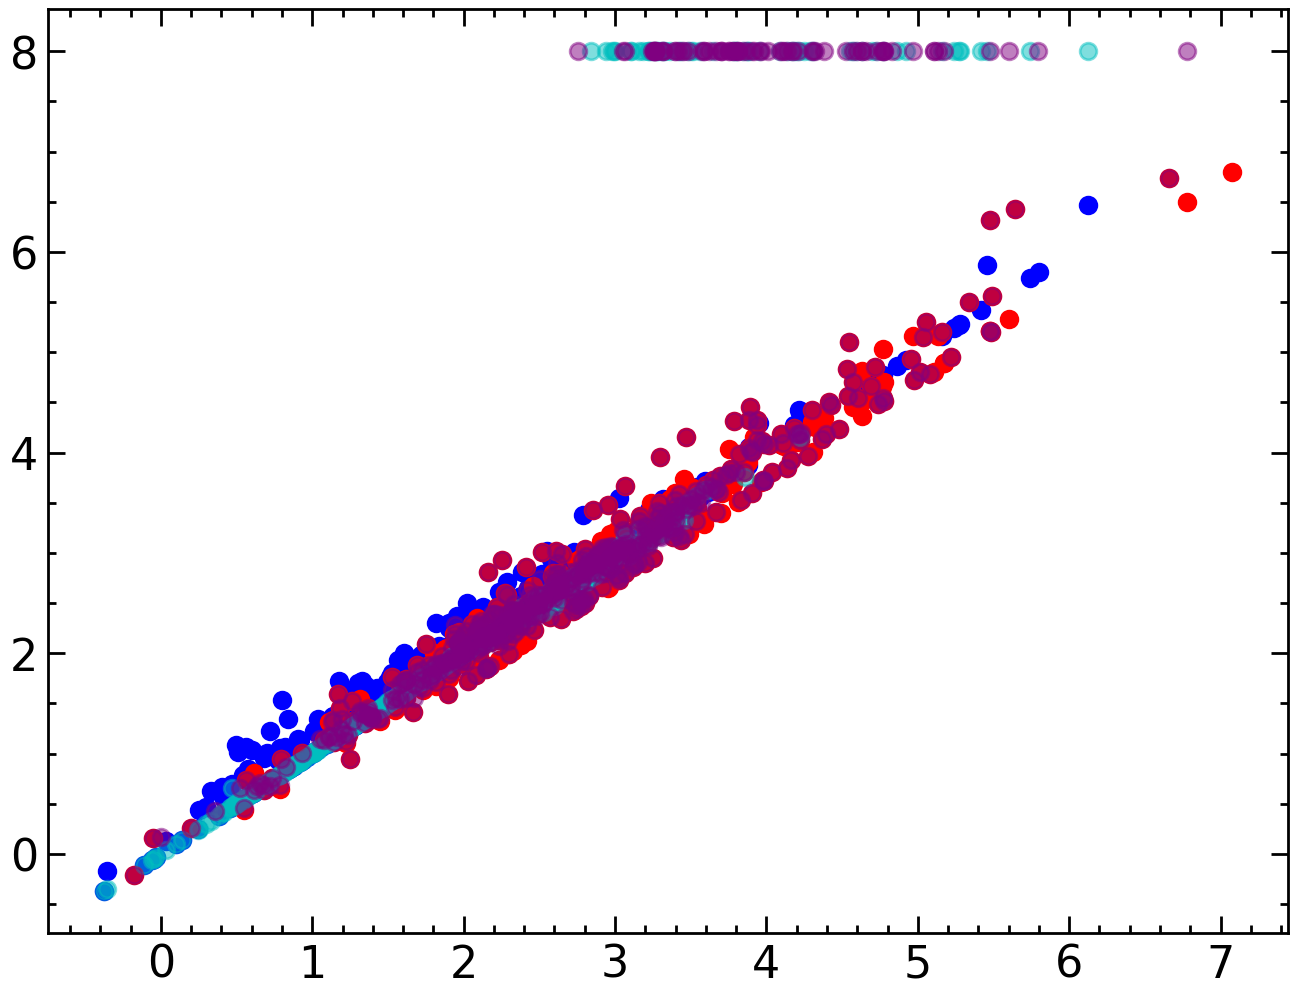

In [538]:
plt.scatter(np.log10(mergers_df1.query("period>0").a_before.astype(float)), np.log10(mergers_df1.query("period>0").a.astype(float)), color='b', alpha = 1.0)
plt.scatter(np.log10(mergers_df6.query("period>0").a_before.astype(float)), np.log10(mergers_df6.query("period>0").a.astype(float)), color='r', alpha = 1.0)

plt.scatter(np.log10(mergers_df1_kicks.query("period>0").a_before.astype(float)), np.log10(mergers_df1_kicks.query("period>0").a.astype(float)), color = 'c', alpha = 0.5)
plt.scatter(np.log10(mergers_df6_kicks.query("period>0").a_before.astype(float)), np.log10(mergers_df6_kicks.query("period>0").a.astype(float)), color = 'purple', alpha = 0.5)

In [489]:
mergers_df6.value_counts('bintype')

bintype
WDWD     486
other     46
MSMS       1
dtype: int64

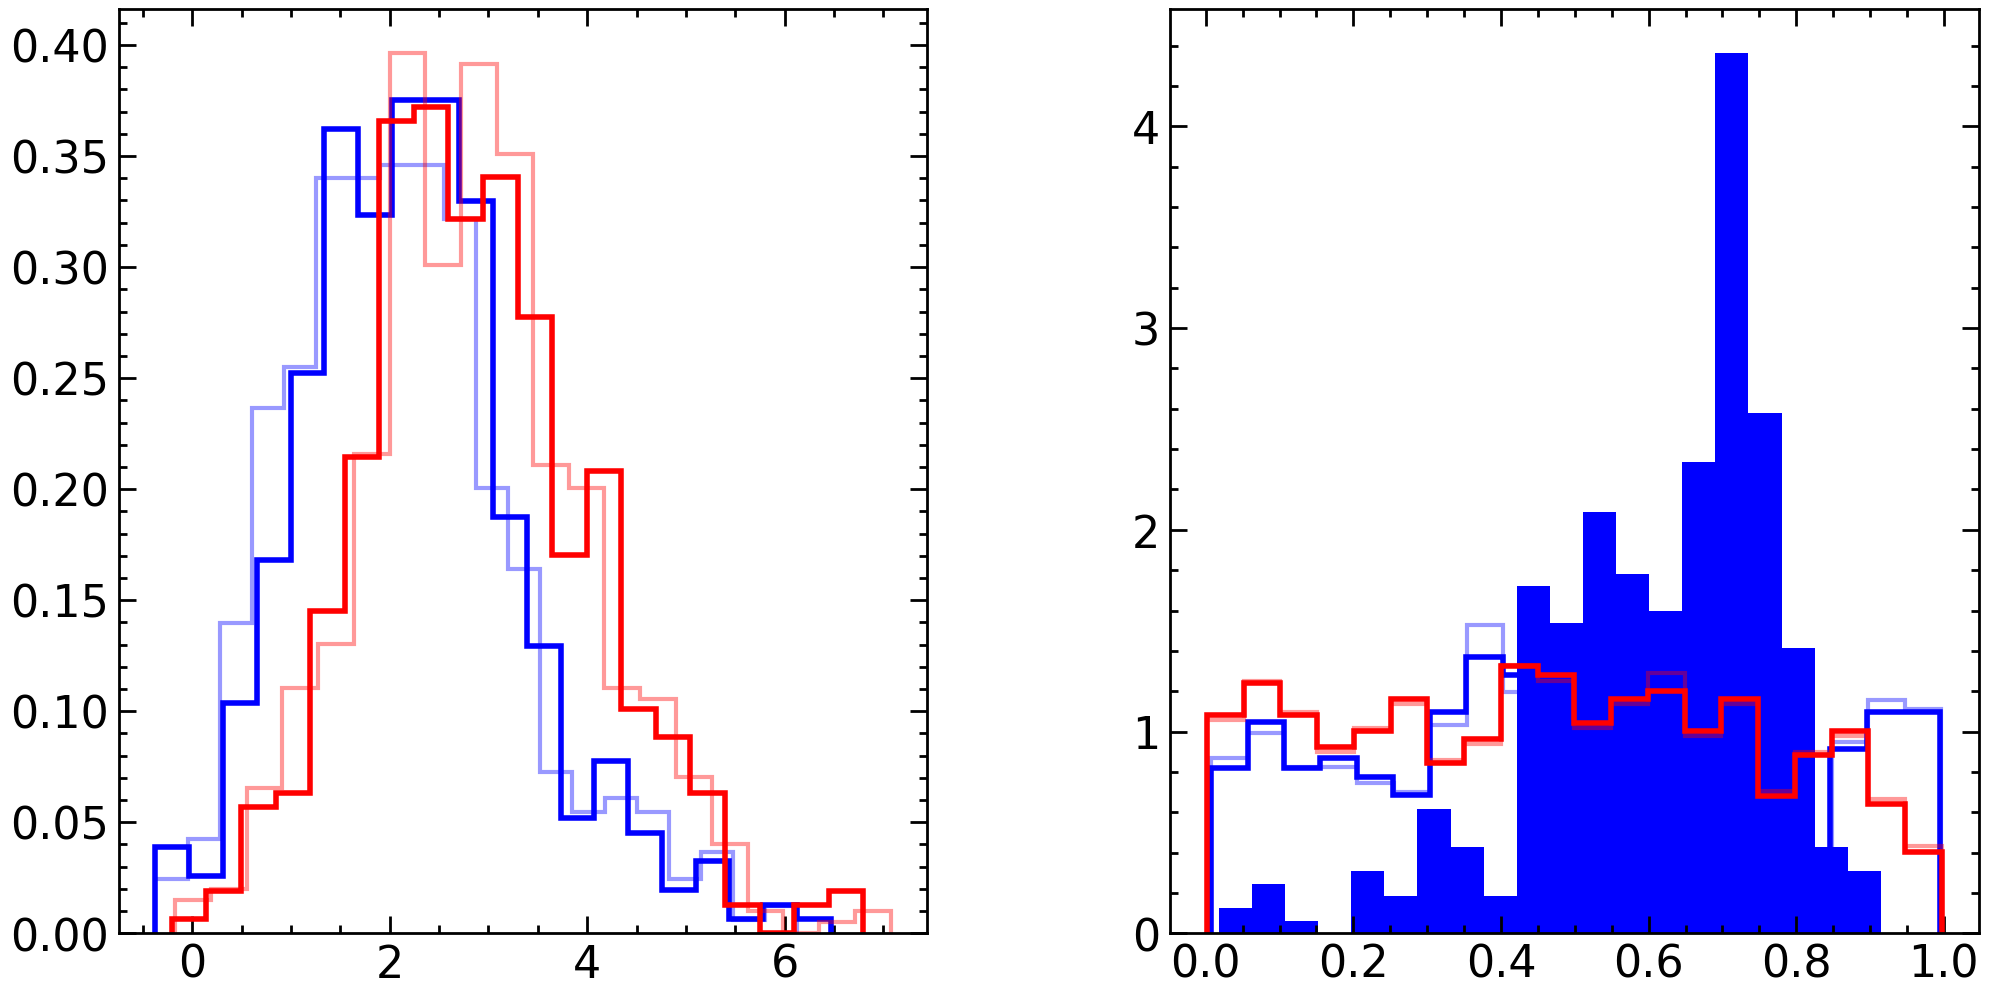

In [539]:
smas_f = np.array(smas_f)
es_f   = np.array(es_f)

fig, axes  = plt.subplots(nrows=1,ncols=2,figsize=(12,6),gridspec_kw=dict(hspace=0,wspace=0.3))
(ax1, ax2) = axes

ax1.hist(np.log10(mergers_df1.query("0< a <1e7").a.sort_values().astype(float)), bins=20,alpha=1.0, density=True, color='b', histtype='step',lw=2.0)
# ax1.hist(np.log10(mergers_df1_kicks.query("0< a <1e7").a.sort_values().astype(float)), bins=20, alpha=0.8, density=True, color='b', histtype='step',lw=1.0,ls='dashed')
ax1.hist(np.log10(merged_df_final1.a2), bins=20, density=True, color='b', histtype='step',lw=1.5, alpha=0.4)

ax1.hist(np.log10(mergers_df6.query("0< a <1e7").a.sort_values().astype(float)), bins=20,alpha=1.0, density=True, color='r', histtype='step',lw=2.0)
# ax1.hist(np.log10(mergers_df6_kicks.query("0< a <1e7").a.sort_values().astype(float)), bins=20, alpha=0.8, density=True, color='r', histtype='step',lw=1.0,ls='dashed')

ax1.hist(np.log10(merged_df_final6.a2), bins=20, alpha=0.4, density=True, color='r', histtype='step',lw=1.5)

ax2.hist(mergers_df1.query("e<1").e, bins=20,alpha=1.0, density=True, color='b', histtype='step',lw=2.0)
ax2.hist(mergers_df1_kicks.query("e<1").e, bins=20,alpha=1.0, density=True, color='b', histtype='stepfilled',lw=1.0)
ax2.hist(merged_df_final1.query("e2 < 1").e2, bins=20, alpha=0.4, density=True, color='b', histtype='step',lw=1.5)

ax2.hist(mergers_df6.query("e<1").e, bins=20,alpha=1.0, density=True, color='r', histtype='step',lw=2.0)
ax2.hist(merged_df_final6.query("e2 < 1").e2, bins=20, alpha=0.4, density=True, color='r', histtype='step',lw=1.5)

np.savetxt(DIR + 'smas_f.txt', smas_f[(smas_f > 0) & (smas_f < 1e7)])

In [425]:
mergers_df6.value_counts('bintype')

bintype
MSMS    533
dtype: int64

In [482]:
mergers_df1

,N,m1,m2,a,period,e,R1,type1,type2,bintype,merger_type,triptype_before,t_old,type1_before,type2_before,m1_before,m2_before,a_before,period_before,e_before,R1_after,startype1,startype2
0,1000,0.088818,0.088818,2471.267053,291484.236161,0.593847,0.028749,10.0,10.0,WDWD,WDWD,WDWD-MS,2695419362.933425,10.0,0,0.088818,0.5314,707.790135,23910.283433,0.593847,0.028749,WD,WD
1,1001,0.952065,0.952065,51.470677,267.603399,0.363088,0.008596,11.0,11.0,WDWD,MSMS,MSMS-MS,638488879.856111,11.0,1,0.952065,0.8482,54.440229,299.372395,0.363088,0.008596,WD,WD
2,1002,0.0,0.0,inf,inf,0.953379,0.0,15.0,15.0,other,RGMS,RGMS-MS,9051704779.89768,15.0,1,0.0,0.8577,18.748001,87.652592,0.953379,3.699609,other,other
3,1005,0.738303,0.738303,202.15849,2365.405475,0.638229,0.011033,11.0,11.0,WDWD,MSMS,MSMS-MS,134529868.459804,11.0,0,0.738303,0.617,220.252209,2807.774173,0.638229,0.011033,WD,WD
4,1008,0.543864,0.543864,7.706541,20.512988,0.67937,0.013565,11.0,11.0,WDWD,WDMS,WDMS-MS,3434608361.535715,11.0,0,0.543864,0.5631,7.572626,19.806279,0.67937,0.013565,WD,WD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,1985,0.609717,0.609717,809.607062,20860.855287,0.930475,0.012648,11.0,11.0,WDWD,RGMS,RGMS-MS,897708360.73755,11.0,0,0.609717,0.1972,1223.499527,47642.127462,0.930475,0.012648,WD,WD
453,1994,0.520255,0.520255,49.034086,336.607734,0.489196,0.013915,11.0,11.0,WDWD,WDMS,WDMS-MS,2278886147.57715,11.0,0,0.520255,0.5552,47.440799,315.088039,0.489196,0.013915,WD,WD
454,1996,0.513931,0.513931,114.364941,1206.34567,0.408546,0.014011,11.0,11.0,WDWD,WDMS,WDMS-MS,4803237270.016114,11.0,1,0.513931,0.8261,87.722926,709.761057,0.408546,0.014011,WD,WD
455,1997,0.5931,0.5931,190.039783,2405.403401,0.407685,0.012872,11.0,11.0,WDWD,RGMS,RGMS-MS,2789508104.270862,11.0,0,0.5931,0.1117,319.842757,6813.525894,0.407685,0.012872,WD,WD


In [542]:
mergers_df6.value_counts("bintype")

bintype
MSMS     292
WDWD     153
other     80
RGRG       8
dtype: int64

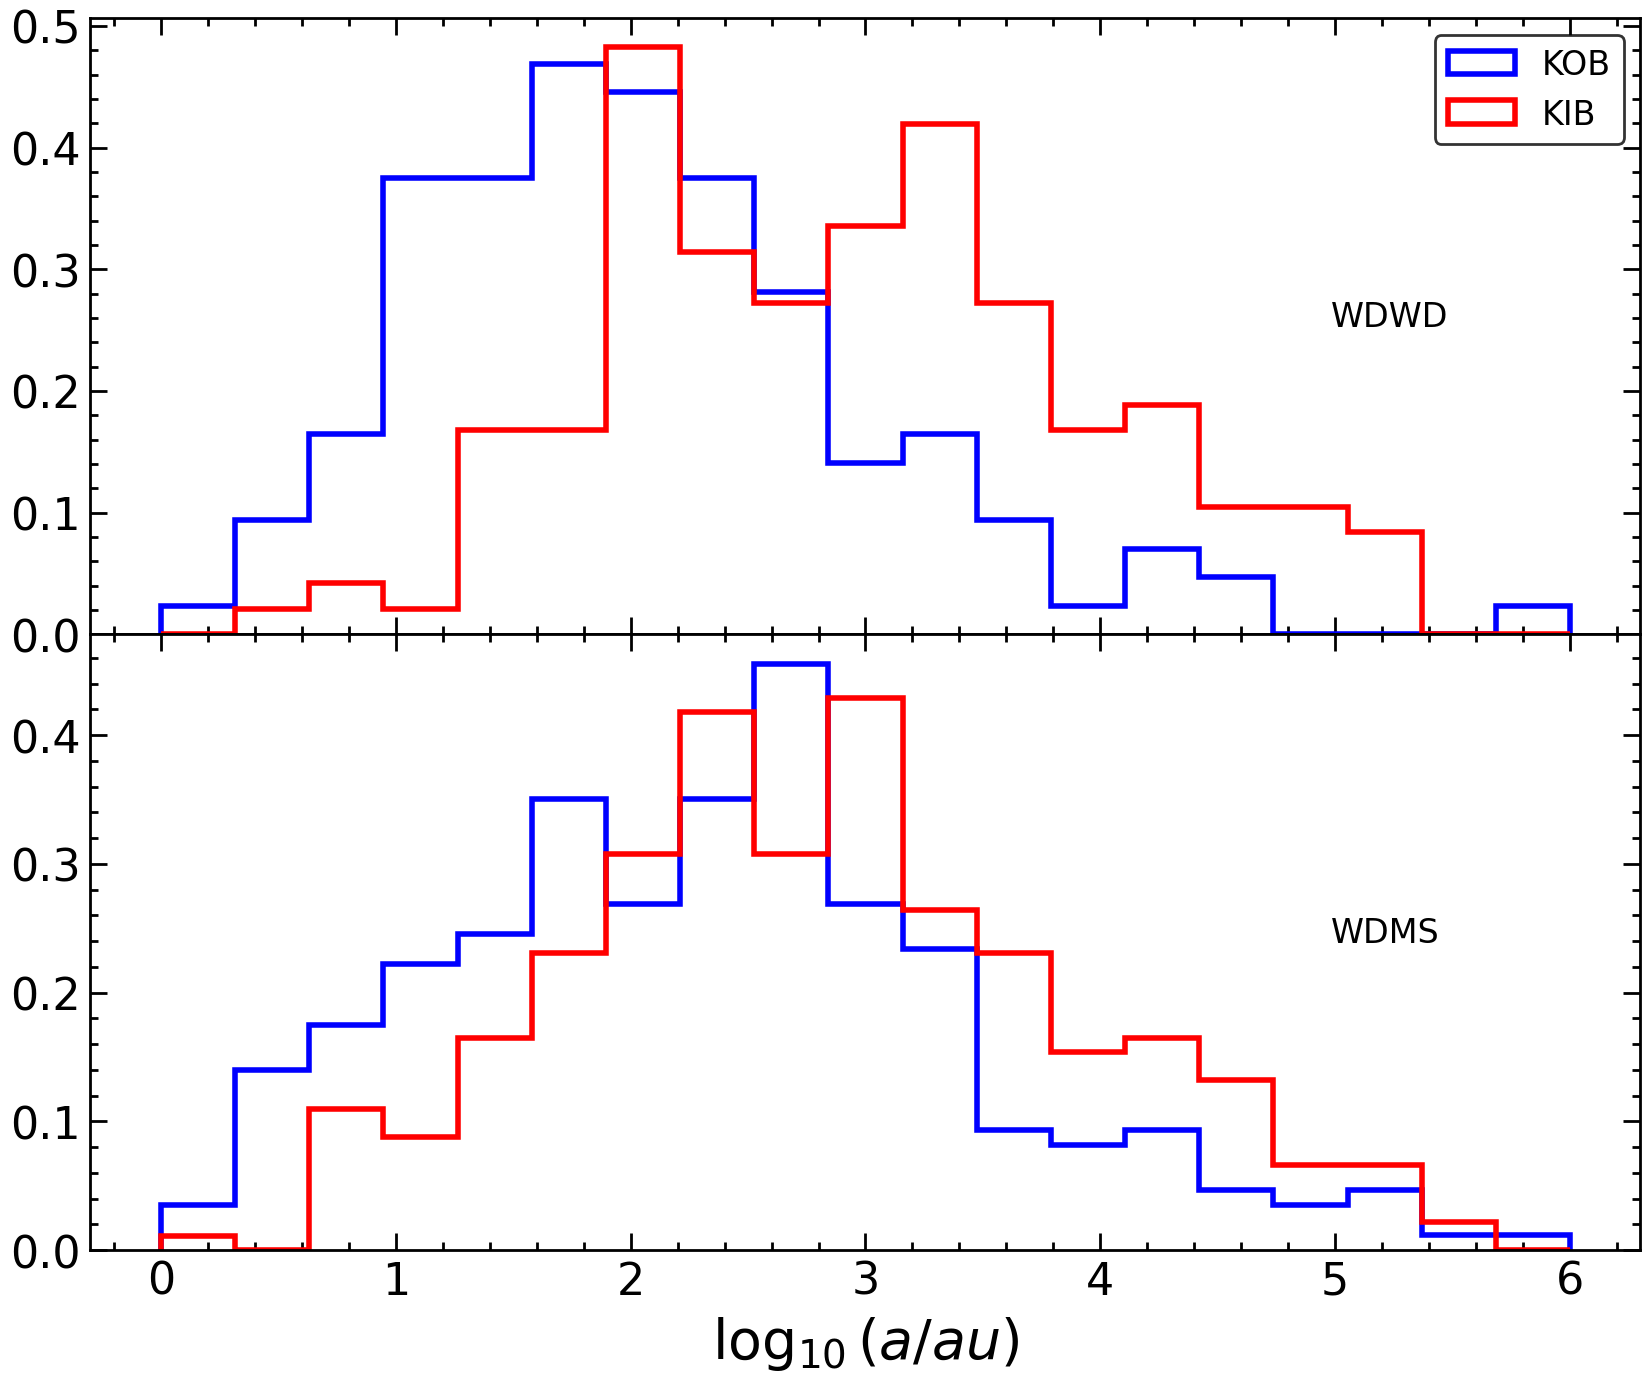

In [543]:
plt.style.use(['science','notebook'])
%config InlineBackend.figure_format = 'retina'

fig, axes  = plt.subplots(nrows=2,ncols=1,figsize=(10,8),gridspec_kw=dict(hspace=0,wspace=0.0),sharex=True)
(ax1, ax2) = axes

kwargs_hist = {'histtype' :'step','density':True, 'lw' : 2.0}

bins = np.linspace(0,6,20)
ax1.hist(np.log10(mergers_df1.query("bintype == 'WDWD' and 0 < a <1e6")['a'].astype(float)), color='b', label = 'KOB', bins=bins, **kwargs_hist)
ax1.hist(np.log10(mergers_df6.query("bintype == 'WDWD' and 0 < a <1e6")['a'].astype(float)), color='r', label = 'KIB', bins=bins, **kwargs_hist)

ax2.hist(np.log10(mergers_df1.query("bintype == 'WDMS' and 0 < a <1e6")['a'].astype(float)), color='b', label = 'KOB WDMS', bins=bins, **kwargs_hist)
ax2.hist(np.log10(mergers_df6.query("bintype == 'MSMS' and 0 < a <1e6")['a'].astype(float)), color='r', label = 'KIB WDMS', bins=bins, **kwargs_hist)

ax1.legend(frameon=-1, edgecolor='k', fontsize=12)
ax1.text(0.8, 0.5, 'WDWD', transform = ax1.transAxes, fontsize=12)
ax2.text(0.8, 0.5, 'WDMS', transform = ax2.transAxes, fontsize=12)
ax2.set_xlabel("$\log_{10}(a / au)$", fontsize=20);


# Calculating the New Parameters after SSE

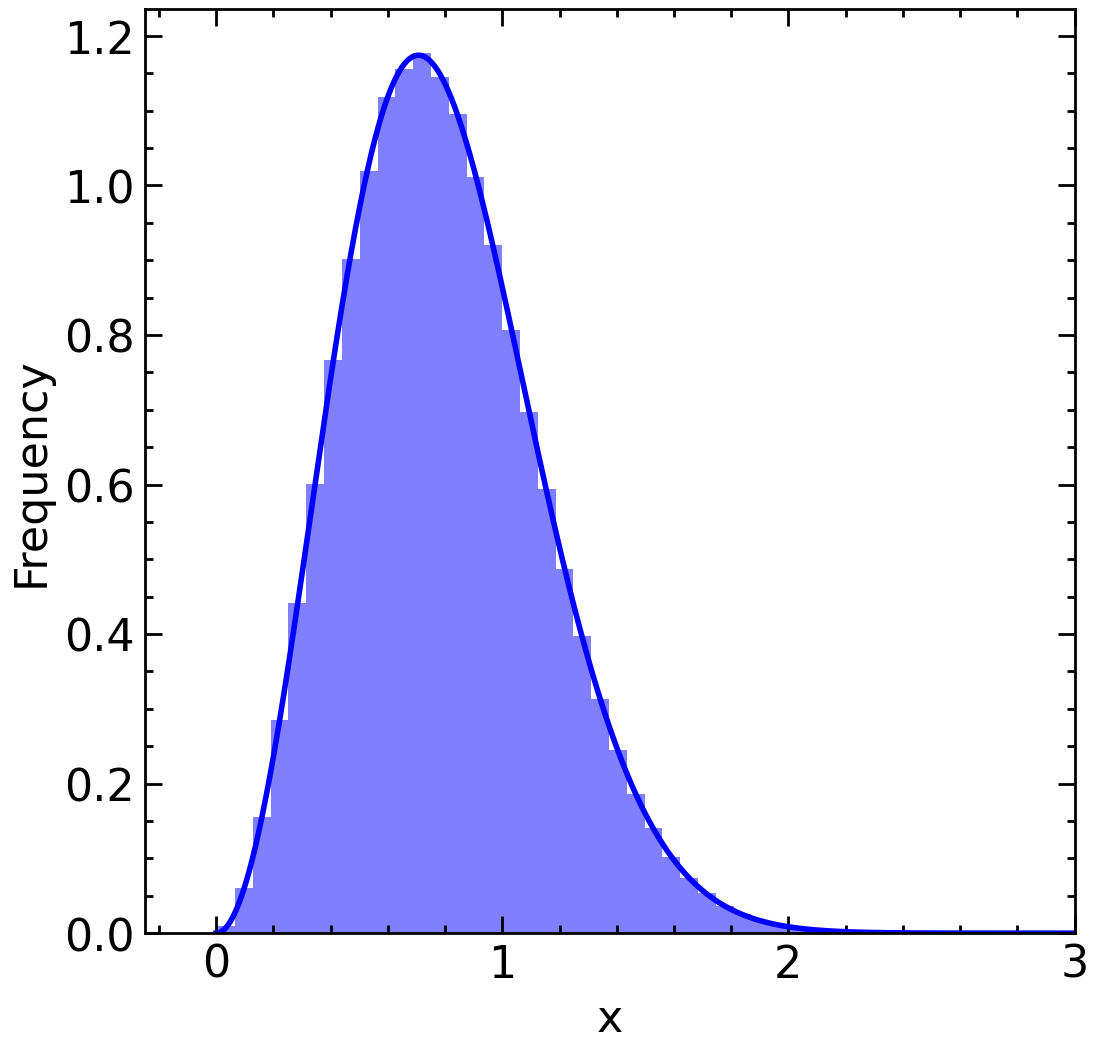

In [376]:
# Distribution of kick magnitudes 

def my_pdf(vk):
    sigma = 0.5 #km/s
    return (np.sqrt(2/np.pi) * (vk**2)/(sigma**3) * np.exp(-1* (vk**2) / (2*sigma**2) ))

# Define the range of x values to consider
x = np.linspace(0, 5, 10000)
plt.figure(figsize=(6,6))
# Plot the PDF
plt.plot(x, my_pdf(x),color='b')
plt.xlabel('x')
plt.ylabel('PDF')

# Choose random values from the PDF
num_samples = 10000000 # Number of random samples to choose
samples = np.random.choice(x, size=num_samples, p=my_pdf(x)/np.sum(my_pdf(x)))

# Plot the histogram of the random samples
plt.hist(samples, density=True, bins=50, histtype='stepfilled', lw=3, fc=(0, 0, 1, 0.5))
plt.xlim(right=3)
plt.xlabel('x')
plt.ylabel('Frequency')
plt.show()

In [181]:
get_a2_kick(m1_i = 1, m2_i = 1, m1_n = 0.5, m2_n = 1, e_i = 0.5, a_i = 1, sample=True, N_sample = 1000, zero_kick=False)

(1.43366674510689, 0.5424894997910404)

In [182]:
!pip3 install amuse-framework
!pip3 install amuse


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 675.4/675.4 kB 842.1 kB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached setuptools_scm-7.1.0-py3-none-any.whl (43 kB)
  Using cached docutils-0.20.1-py3-none-any.whl (572 kB)
  Created wheel for amuse-framework: filename=amuse_framework-2023.5.0-py3-none-any.whl size=609623 sha256=56404fc2040e3132a6acc8311d44db3f1d4286fa881478ee80faebbc7ad03421
  Stored in directory: /Users/bijan1339/Library/Caches/pip/wheels/26/ea/ae/f99a503950f2c3528f77ec0e22c9fd59d840fc047aab260f3c
Successfully built amuse-framework
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
  Installing build dependencies ... |^C
anceled
ERROR: Operation cancelled by us